### Investigation of `used_ocr`

Investigation into `used_ocr` feature is important, because looking at the extraction code below:
```python
        try:
            doc = fitz.open(filepath)
            font_names = set()
            for page in doc:
                features["image_count"] += len(page.get_images(full=True))
                font_names.update([f[3] for f in page.get_fonts() if f[3]])
            features["font_object_count"] = len(font_names)
            features["object_count"] = doc.xref_length()
            features["xref_entries"] = sum(1 for i in range(doc.xref_length()) if doc.xref_object(i, compressed=False))
            features["text_length"] = sum(len(page.get_text()) for page in doc)
        except Exception:
            text = extract_text_pdfminer(filepath) or extract_text_pdftotext(filepath)
            if not text.strip():
                text = extract_text_ocr(filepath)
                features["used_ocr"] = 1
            features["text_length"] = len(text)
```
The `used_ocr` feature is 1 when fitz fails to parse the file, resulting in a fallback in which ocr is used with pdfminer or pdftotext. The ocr of the pdf file will produce broken counts of objects because it cannot parse the file but only perform character recognition on visible text. We investigate the variance in rows where `used_ocr = 1` in the cell below

In [1]:
import polars as pl
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_pdf = pl.read_csv("datasets/PDF_All_features.csv")

# Section 1: Preliminary Check

### Step 1: Checking Data Leakage

In [4]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

A Model is trained with only the `used_ocr` feature to see if there is data_leakage. If the accuracy is high enough, then it means that `used_ocr` is in someway representative of label

In [5]:
X_cheat = df_pdf.select(["used_ocr"]).to_numpy()
y = df_pdf["label"].to_numpy()

# 2. Train a Model
model_cheat = XGBClassifier(eval_metric='logloss')
model_cheat.fit(X_cheat, y)

# 3. Measure Accuracy
y_pred = model_cheat.predict(X_cheat)
acc = accuracy_score(y, y_pred)

print(f"Accuracy using ONLY 'used_ocr': {acc:.2%}")

Accuracy using ONLY 'used_ocr': 57.50%


### Step 2: Checking Correlation
A high correlation can also be indicative of Data Leakage

In [6]:
# Calculate correlation
corr_val = df_pdf.select(pl.corr("used_ocr", "label")).item()

print(f"Correlation between used_ocr and Label: {corr_val:.4f}")

Correlation between used_ocr and Label: -0.1658


### Step 3: Checking most important features
If `used_ocr` is very important in the dataset, then it should be removed due to its impact

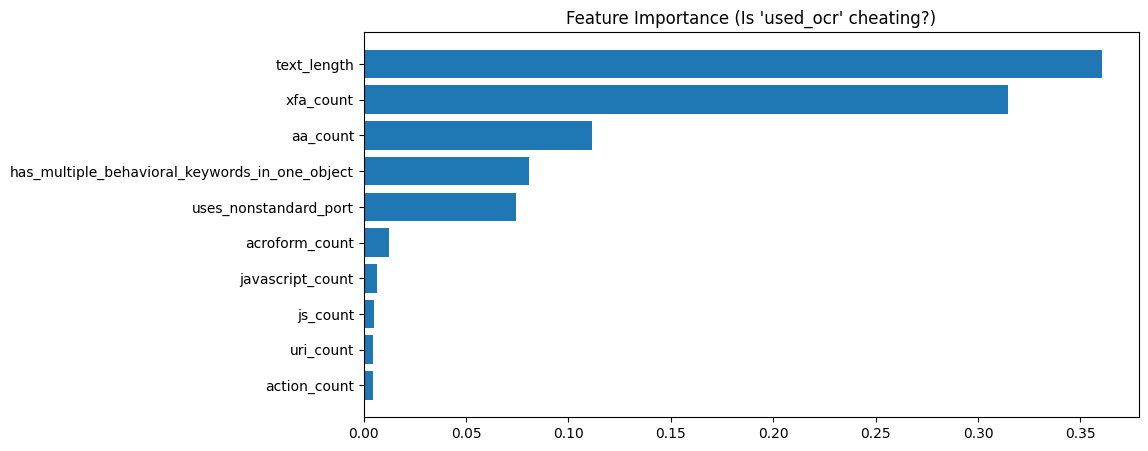

In [7]:
numeric_cols = df_pdf.select(pl.col(pl.Int64, pl.Float64)).columns
if "label" in numeric_cols: numeric_cols.remove("label")

X_all = df_pdf.select(numeric_cols).to_numpy()
model_all = XGBClassifier(eval_metric='logloss')
model_all.fit(X_all, y)

# 2. Get Importance
importance = model_all.feature_importances_
feat_names = numeric_cols

# 3. Sort and Plot Top 10
sorted_idx = importance.argsort()[::-1][:10]
plt.figure(figsize=(10, 5))
plt.title("Feature Importance (Is 'used_ocr' cheating?)")
plt.barh([feat_names[i] for i in sorted_idx], importance[sorted_idx])
plt.gca().invert_yaxis()
plt.show()

### Results
So based on this preliminary investigation, it is clear that `used_ocr` does not have a high correlation, is not a very important column to the dataset, and neither leaks data about the label. 

However, looking at the extraction code, it is clear that there must be some other sort of impact on the dataset. This is analyzed in the section below

# Section 2: Bias Checking

Since a different library is used to extract features, it is quite possible that a bias is imparted onto the rows with `used_ocr = 1`. This is checked in the section using the KS (Kolmogorov-Smirnov) Test.

In [10]:
group_ocr = df_pdf.filter(pl.col("used_ocr") == 1)
group_clean = df_pdf.filter(pl.col("used_ocr") == 0)

print(f"Comparing {group_ocr.height} OCR files vs {group_clean.height} Clean files...")

numeric_cols = df_pdf.select(pl.col(pl.Int64, pl.Float64)).columns
if "label" in numeric_cols: numeric_cols.remove("label")
if "used_ocr" in numeric_cols: numeric_cols.remove("used_ocr")

biased_features = []

print(f"\n{'FEATURE':<30} | {'KS STAT':<10} | {'P-VALUE':<10} | {'CONCLUSION'}")
print("-" * 75)

for col in numeric_cols:
    # Extract data as numpy arrays
    data_ocr = group_ocr[col].to_numpy()
    data_clean = group_clean[col].to_numpy()
    
    # KS Test: Compares the cumulative distributions
    # statistic: 0.0 (identical) -> 1.0 (completely different)
    stat, p_value = ks_2samp(data_ocr, data_clean)
    
    # Define threshold for "Significant Bias"
    # KS > 0.3 implies significant distributional shift
    is_biased = stat > 0.3 and p_value < 0.05
    
    conclusion = "BIASED" if is_biased else "Stable"
    print(f"{col:<30} | {stat:.4f}     | {p_value:.1e}    | {conclusion}")
    
    if is_biased:
        biased_features.append((col, stat))

# --- 3. SUMMARY OUTPUT ---
# Sort biased features by KS Statistic (highest bias first)
biased_features.sort(key=lambda x: x[1], reverse=True)
top_biased = [x[0] for x in biased_features[:3]]

print(f"\nTop 3 Most Biased Features: {top_biased}")

Comparing 3414 OCR files vs 15882 Clean files...

FEATURE                        | KS STAT    | P-VALUE    | CONCLUSION
---------------------------------------------------------------------------
file_size                      | 0.2856     | 2.1e-203    | Stable
title_chars                    | 0.5057     | 0.0e+00    | BIASED
encrypted                      | 0.0042     | 1.0e+00    | Stable
metadata_size                  | 0.4736     | 0.0e+00    | BIASED
page_count                     | 0.4687     | 0.0e+00    | BIASED
valid_pdf_header               | 0.4719     | 0.0e+00    | BIASED
image_count                    | 0.5826     | 0.0e+00    | BIASED
text_length                    | 0.4707     | 0.0e+00    | BIASED
object_count                   | 0.4719     | 0.0e+00    | BIASED
font_object_count              | 0.4227     | 0.0e+00    | BIASED
embedded_file_count            | 0.0000     | 1.0e+00    | Stable
average_embedded_file_size     | 0.0000     | 1.0e+00    | Stable
stream_coun

Looking at the biased columns (`metadata_size`, `page_count` ,`valid_pdf_header`, `image_count`, `text_length`, `object_count`, `font_object_count`, `title_chars`, `total_filters`, `stream_count`, `endstream_count`, `average_stream_size`, `entropy_of_streams`), it is understood that most of these features are structural, or related to stream, and are corrupted due to fitz failing. But all the other features are not biased, meaning that the extraction for all the other features worked perfectly. The behavioral rows are not biased, and if a classifier should be trained, then it would be much rather preferred that it learns beahvioral features rather than structural, to be a good classifier.



# Conclusion

Since the dataset is small, and behavioural features are unbiased, the decision is made to keep the `used_ocr=1` rows